In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
                
import numpy as np
import pandas as pd
#np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [3]:
clinical = pd.read_csv("../../data/TCGA/rna-seq_pan/meta/clinical.tsv", sep='\t')
clinical.head()

,case_id,submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,created_datetime,days_to_birth,days_to_death,demographic_id,ethnicity,gender,occupation_duration_years,premature_at_birth,race,state,submitter_id.1,updated_datetime,vital_status,weeks_gestation_at_birth,year_of_birth,year_of_death,age_at_diagnosis,ajcc_clinical_m,ajcc_clinical_n,ajcc_clinical_stage,ajcc_clinical_t,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_staging_system_edition,anaplasia_present,anaplasia_present_type,ann_arbor_b_symptoms,ann_arbor_clinical_stage,ann_arbor_extranodal_involvement,ann_arbor_pathologic_stage,annotation_id,case_id.1,case_submitter_id,category,classification,created_datetime.1,creator,entity_id,entity_submitter_id,entity_type,legacy_created_datetime,legacy_updated_datetime,notes,state.1,status,submitter_id.2,updated_datetime.1,best_overall_response,breslow_thickness,burkitt_lymphoma_clinical_variant,child_pugh_classification,circumferential_resection_margin,classification_of_tumor,cog_liver_stage,cog_neuroblastoma_risk_group,cog_renal_stage,cog_rhabdomyosarcoma_risk_group,created_datetime.2,days_to_best_overall_response,days_to_diagnosis,days_to_last_follow_up,days_to_last_known_disease_status,days_to_recurrence,diagnosis_id,enneking_msts_grade,enneking_msts_metastasis,enneking_msts_stage,enneking_msts_tumor_site,esophageal_columnar_dysplasia_degree,esophageal_columnar_metaplasia_present,figo_stage,first_symptom_prior_to_diagnosis,gastric_esophageal_junction_involvement,gleason_grade_group,goblet_cells_columnar_mucosa_present,gross_tumor_weight,icd_10_code,igcccg_stage,inpc_grade,inpc_histologic_group,inrg_stage,inss_stage,international_prognostic_index,irs_group,irs_stage,ishak_fibrosis_score,iss_stage,largest_extrapelvic_peritoneal_focus,last_known_disease_status,laterality,lymph_nodes_positive,lymph_nodes_tested,lymphatic_invasion_present,masaoka_stage,medulloblastoma_molecular_classification,metastasis_at_diagnosis,metastasis_at_diagnosis_site,method_of_diagnosis,micropapillary_features,mitosis_karyorrhexis_index,mitotic_count,morphology,non_nodal_regional_disease,non_nodal_tumor_deposits,ovarian_specimen_status,ovarian_surface_involvement,percent_tumor_invasion,perineural_invasion_present,peripancreatic_lymph_nodes_positive,peripancreatic_lymph_nodes_tested,peritoneal_fluid_cytological_status,primary_diagnosis,primary_gleason_grade,prior_malignancy,prior_treatment,progression_or_recurrence,residual_disease,secondary_gleason_grade,site_of_resection_or_biopsy,state.2,submitter_id.3,supratentorial_localization,synchronous_malignancy,tissue_or_organ_of_origin,created_datetime.3,days_to_treatment_end,days_to_treatment_start,initial_disease_status,regimen_or_line_of_therapy,state.3,submitter_id.4,therapeutic_agents,treatment_anatomic_site,treatment_effect,treatment_id,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type,updated_datetime.2,tumor_confined_to_organ_of_origin,tumor_focality,tumor_grade,tumor_largest_dimension_diameter,tumor_regression_grade,tumor_stage,updated_datetime.3,vascular_invasion_present,vascular_invasion_type,weiss_assessment_score,wilms_tumor_histologic_subtype,year_of_diagnosis
0,2ca47049-bc12-4992-b9cf-1c01dda639be,TCGA-60-2708,TCGA-LUSC,64,--,--,--,--,-23691,--,205ebbeb-a679-5425-aa53-b46254f0c70e,not hispanic or latino,female,--,--,white,released,TCGA-60-2708_demographic,2019-07-31T19:15:49.243494-05:00,Alive,--,1940,--,23691,--,--,--,--,M0,N1,Stage IIB,T2,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,not reported,--,--,--,--,--,--,--,2447,--,--,7402e4eb-e3da-5af2-b214-69ce6a68c9ad,--,--,--,--,--,--,--,--,--,--,--,--,C34.3,--,--,--,--,--,--,--,--,--,--,--,not reported,--,--,--,--,--,--,--,--,--,--,--,--,8070/3,--,--,--,--,--,--,--,--,--,"Squamous cell carcinoma, NOS",--,no,No,not reported,--,--,"Lower lobe, lung",released,TCGA-60-2708_diagnosis,--,No,"Lower lobe, lung",20

In [4]:
clinical[clinical['project_id']=='TCGA-SKCM']['tumor_stage'].value_counts()

stage iiic      134
stage iic       128
stage iiib       88
stage iii        82
not reported     76
stage ii         60
stage i          58
stage ib         58
stage iib        56
stage iv         46
stage iia        36
stage ia         34
stage iiia       32
i/ii nos         28
stage 0          14
Name: tumor_stage, dtype: int64

In [5]:
samples = pd.read_csv('../../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['Meta ID'] = samples['Project ID'].str.cat(samples['Sample Type'], sep=":")
samples['Meta ID'].value_counts()[:30]

TCGA-BRCA:Primary Tumor                                      1087
TCGA-UCEC:Primary Tumor                                       544
TCGA-LUAD:Primary Tumor                                       528
TCGA-LGG:Primary Tumor                                        506
TCGA-LUSC:Primary Tumor                                       496
TCGA-KIRC:Primary Tumor                                       483
TCGA-PRAD:Primary Tumor                                       466
TCGA-COAD:Primary Tumor                                       465
TCGA-THCA:Primary Tumor                                       445
TCGA-BLCA:Primary Tumor                                       412
TCGA-OV:Primary Tumor                                         374
TCGA-STAD:Primary Tumor                                       370
TCGA-LIHC:Primary Tumor                                       369
TCGA-SKCM:Metastatic                                          364
TCGA-CESC:Primary Tumor                                       301
TCGA-KIRP:

In [6]:
sample_grp = samples.groupby(['Sample Type', 'Project ID'])
sample_grp.size()['Solid Tissue Normal'].nlargest(6)
projects = list(sample_grp.size()['Solid Tissue Normal'].nlargest(5).index)
projects.append('TCGA-SKCM')
types = ['Solid Tissue Normal', 'Primary Tumor']

Project ID
TCGA-BRCA    112
TCGA-KIRC     70
TCGA-LUAD     58
TCGA-THCA     53
TCGA-PRAD     50
TCGA-LIHC     49
dtype: int64

In [7]:
samples[samples['Project ID'].isin(projects)].groupby(['Sample Type', 'Project ID']).size()

Sample Type               Project ID
Additional - New Primary  TCGA-KIRC        1
Additional Metastatic     TCGA-SKCM        1
Metastatic                TCGA-BRCA        7
                          TCGA-PRAD        1
                          TCGA-SKCM      364
                          TCGA-THCA        7
Primary Tumor             TCGA-BRCA     1087
                          TCGA-KIRC      483
                          TCGA-LUAD      528
                          TCGA-PRAD      466
                          TCGA-SKCM      103
                          TCGA-THCA      445
Recurrent Tumor           TCGA-LUAD        2
Solid Tissue Normal       TCGA-BRCA      112
                          TCGA-KIRC       70
                          TCGA-LUAD       58
                          TCGA-PRAD       50
                          TCGA-SKCM        1
                          TCGA-THCA       53
dtype: int64

In [8]:
# all cases with adjacent normal tissue
cases = samples[(samples['Project ID'].isin(projects)) & 
                (samples['Sample Type'].isin(types))]['Case ID'].unique()
cases.shape

(3076,)

In [9]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Metastatic') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()

3072

18

344

In [10]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM')]
#cases = pd.merge(case_tumor['Case ID'], case_norm['Case ID'])['Case ID']
cases = pd.concat([case_tumor, case_norm]).sample(frac=1)
# remove single TCGA-SKCM:Solid Tissue Normal
cases = cases[cases['Meta ID'] != 'TCGA-SKCM:Solid Tissue Normal']
cases.shape

(3455, 10)

In [11]:
cases['Meta ID'].value_counts()

TCGA-BRCA:Primary Tumor          1087
TCGA-LUAD:Primary Tumor           528
TCGA-KIRC:Primary Tumor           483
TCGA-PRAD:Primary Tumor           466
TCGA-THCA:Primary Tumor           445
TCGA-BRCA:Solid Tissue Normal     112
TCGA-SKCM:Primary Tumor           103
TCGA-KIRC:Solid Tissue Normal      70
TCGA-LUAD:Solid Tissue Normal      58
TCGA-THCA:Solid Tissue Normal      53
TCGA-PRAD:Solid Tissue Normal      50
Name: Meta ID, dtype: int64

In [12]:
case_tumor.shape
case_norm.shape
cases.shape

(3112, 10)

(344, 10)

(3455, 10)

## CCLE Model Systems

In [20]:
ccle = pd.read_csv("../../data/DepMap/CCLE_expression.csv", index_col=0)
ccle.head()

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),STPG1 (90529),NIPAL3 (57185),LAS1L (81887),ENPP4 (22875),SEMA3F (6405),CFTR (1080),ANKIB1 (54467),CYP51A1 (1595),KRIT1 (889),RAD52 (5893),BAD (572),LAP3 (51056),CD99 (4267),HS3ST1 (9957),AOC1 (26),WNT16 (51384),HECW1 (23072),MAD1L1 (8379),LASP1 (3927),SNX11 (29916),TMEM176A (55365),M6PR (4074),KLHL13 (90293),CYP26B1 (56603),ICA1 (3382),DBNDD1 (79007),ALS2 (57679),CASP10 (843),CFLAR (8837),TFPI (7035),NDUFAF7 (55471),RBM5 (10181),MTMR7 (9108),SLC7A2 (6542),ARF5 (381),SARM1 (23098),POLDIP2 (26073),PLXND1 (23129),AK2 (204),CD38 (952),FKBP4 (2288),KDM1A (23028),RBM6 (10180),CAMKK1 (84254),RECQL (5965),VPS50 (55610),HSPB6 (126393),ARHGAP33 (115703),NDUFAB1 (4706),PDK4 (5166),SLC22A16 (85413),ZMYND10 (51364),ABCB5 (340273),ARX (170302),SLC25A13 (10165),ST7 (7982),CDC27 (996),SLC4A1 (6521),CALCR (799),HCCS (3052),DVL2 (1856),PRSS22 (64063),UPF1 (5976),SKAP2 (8935),SLC25A5 (292),MCUB (55013),HOXA11 (3207),POLR2J (5439),DHX33 (56919),MEOX1 (4222),THSD7A (221981),LIG3 (3980),RPAP3 (79657),ACSM3 (6296),REXO5 (81691),CIAPIN1 (57019),SPPL2B (56928),FAM214B (80256),COPZ2 (51226),PRKAR2B (5577),MSL3 (10943),CREBBP (1387),TSPOAP1 (9256),MPO (4353),PON1 (5444),GCFC2 (6936),WDR54 (84058),CROT (54677),ABCB4 (5244),KMT2E (55904),RHBDD2 (57414),SOX8 (30812),IBTK (25998),ZNF195 (7748),MYCBP2 (23077),FBXL3 (26224),ITGAL (3683),PDK2 (5164),ITGA3 (3675),ZFX (7543),LAMP2 (3920),ITGA2B (3674),ASB4 (51666),GDE1 (51573),REX1BD (55049),CRLF1 (9244),OSBPL7 (114881),TMEM98 (26022),YBX2 (51087),KRT33A (3883),MAP3K14 (9020),ABCC8 (6833),CACNG3 (10368),TMEM132A (54972),AP2B1 (163),TAC1 (6863),ZNF263 (10127),CX3CL1 (6376),SPATA20 (64847),CACNA1G (8913),TNFRSF12A (51330),DLX6 (1750),MAP3K9 (4293),RALA (5898),BAIAP2L1 (55971),KDM7A (80853),ETV1 (2115),AGK (55750),ALDH3B1 (221),TTC22 (55001),PHTF2 (57157),CCL26 (10344),FARP2 (9855),USH1C (10083),GGCT (79017),DBF4 (10926),TBXA2R (6915),IFRD1 (3475),LGALS14 (56891),COX10 (1352),GTF2IRD1 (9569),PAF1 (54623),VPS41 (27072),ARHGAP44 (9912),ELAC2 (60528),SCIN (85477),ARSD (414),PNPLA4 (8228),MYH13 (8735),ADIPOR2 (79602),CDKL3 (51265),UPP2 (151531),PRSS21 (10942),MARK4 (57787),PROM1 (8842),CCDC124 (115098),CEACAM21 (90273),PAFAH1B1 (5048),NOS2 (4843),DNAH9 (1770),KIAA0100 (9703),SLC13A2 (9058),GAS7 (8522),TRAPPC6A (79090),MATK (4145),CEACAM7 (1087),CD79B (974),SCN4A (6329),ST7L (54879),TKTL1 (8277),PAX6 (5080),RPUSD1 (113000),RHBDF1 (64285),LUC7L (55692),CACNA2D2 (9254),BAIAP3 (8938),TSR3 (115939),PIGQ (9091),CRAMP1 (57585),TEAD3 (7005),SELE (6401),DNAJC11 (55735),FMO3 (2328),MYLIP (29116),NOX1 (27035),E2F2 (1870),PSMB1 (5689),SYN1 (6853),JARID2 (3720),CDKL5 (6792),CAMK1G (57172),CDK11A (728642),NADK (65220),TFAP2B (7021),TFAP2D (83741),DLEC1 (9940),CYTH3 (9265),ADAM22 (53616),SYPL1 (6856),CYB561 (1534),SPAG9 (9043),CELSR3 (1951),AASS (10157),PLEKHG6 (55200),SS18L2 (51188),MPND (84954),MGST1 (4257),CRY1 (1407),PGLYRP1 (8993),NFIX (4784),ST3GAL1 (6482),MMP25 (64386),IL32 (9235),PKD1 (5310),MAPK8IP2 (23542),MED24 (9862),RHOBTB2 (23221),HEATR5B (54497),SEC62 (7095),RPS20 (6224),CSDE1 (7812),UBE3C (9690),REV3L (5980),TENM1 (10178),PAX7 (5081),MASP2 (10747),IYD (389434),FAM76A (199870),TRAF3IP3 (80342),POMT2 (29954),VTA1 (51534),MLXIPL (51085),BAZ1B (9031),RANBP9 (10048),ETV7 (51513),SPRTN (83932),METTL13 (51603),DYRK4 (8798),ZNF207 (7756),UQCRC1 (7384),STARD3NL (83930),CD9 (928),HHATL (57467),NCAPD2 (9918),IFFO1 (25900),GIPR (2696),PHF7 (51533),SEMA3G (56920),NISCH (11188),STAB1 (23166),FUZ (80199),SLC6A13 (6540),IDS (3423),PRSS3 (5646),ZNF200 (7752),CD4 (920),LRRC23 (10233),BTK (695),HFE (3077),SCMH1 (22955),FYN (2534),HIVEP2 (3097),FMO1 (2326),ELOA (6924),LYPLA2 (11313),CLCN6 (1185),MRC2 (9902),SLC6A7 (6534),TSPAN9 (10867),BTBD7 (55727),APBA3 (9546),MKS1 (54903),ABHD5 (51099),ANOS1 (3730),AKAP8L (26993),MBTD1 (54799),UTP18 (51096),RNF216 (54476),TTC19 (54902),PTBP1 (5725),DPF1 (8193),SYT7 (9066),L

In [21]:
# clean up ccle genes
ccle_genes = pd.DataFrame([[gene[0], gene[1].strip("()")] for gene in ccle.columns.str.split(" ")],
                          columns=["HGNC", "ENTREZ"])
ccle_genes.head()

,HGNC,ENTREZ
0,TSPAN6,7105
1,TNMD,64102
2,DPM1,8813
3,SCYL3,57147
4,C1orf112,55732


## Map Ensembl genes to Proteins

In [22]:
# ID map
hgnc = pd.read_csv("../../../keiser/data/hgnc_mapping_ids/hgnc.txt", sep="\t")
hgnc.shape

(46895, 14)

In [23]:
# downsample to proteins
hgnc_prot = hgnc.dropna(subset=['UniProt ID(supplied by UniProt)'])
hgnc_prot.shape

(20218, 14)

In [24]:
# fraction of overlap between CCLE gene names (ENTREZ/HGNC) and HGNC protein gene names
ccle_genes['ENTREZ'].isin(hgnc_prot['NCBI Gene ID']).sum() / len(hgnc_prot)
ccle_genes['HGNC'].isin(hgnc_prot['Approved symbol']).sum() / len(hgnc_prot)


0.0

0.9323375210208725

### Random sample of proteins

In [25]:
#proteins = proteins.sample(n=10)

## Dataset Prep

Need to ensure test set has health/diseased samples matched for each case

In [26]:
def train_test_split_case(samples, cases, test_size=0.25):
    """
    Splits dataframe into random train and test sets for Siamese network evaluation.
    
    The test set will only contain cases with a single pair of matched samples.
    The train set will contain all others, even cases that have > 2 samples, irrespective if they are exactly matched.
    
    """
    # total test size, round to even number for subsetting test
    n_test = int(len(samples) * test_size)
    if n_test % 2 != 0: n_test = n_test - 1
    # subset samples with a single matched pair
    ids = samples.groupby([cases]).size()
    assert (ids > 1).all(), "Some samples do not have at least a single matched pair."
    ids = ids[ids == 2].index.values
    test_ids = np.random.choice(ids, size=int(n_test/2), replace=False)
    return samples[~samples[cases].isin(test_ids)].reset_index(drop=True), samples[samples[cases].isin(test_ids)].reset_index(drop=True)

- Need to fix train test split so cases are always in either 1 or the other

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Meta ID'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases, test_size=0.25, stratify=cases[target])
train[target].value_counts()
test[target].value_counts()

TCGA-BRCA:Primary Tumor          815
TCGA-LUAD:Primary Tumor          396
TCGA-KIRC:Primary Tumor          362
TCGA-PRAD:Primary Tumor          349
TCGA-THCA:Primary Tumor          334
TCGA-BRCA:Solid Tissue Normal     84
TCGA-SKCM:Primary Tumor           77
TCGA-KIRC:Solid Tissue Normal     52
TCGA-LUAD:Solid Tissue Normal     44
TCGA-THCA:Solid Tissue Normal     40
TCGA-PRAD:Solid Tissue Normal     38
Name: Meta ID, dtype: int64

TCGA-BRCA:Primary Tumor          272
TCGA-LUAD:Primary Tumor          132
TCGA-KIRC:Primary Tumor          121
TCGA-PRAD:Primary Tumor          117
TCGA-THCA:Primary Tumor          111
TCGA-BRCA:Solid Tissue Normal     28
TCGA-SKCM:Primary Tumor           26
TCGA-KIRC:Solid Tissue Normal     18
TCGA-LUAD:Solid Tissue Normal     14
TCGA-THCA:Solid Tissue Normal     13
TCGA-PRAD:Solid Tissue Normal     12
Name: Meta ID, dtype: int64

In [28]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'TCGA-BRCA:Primary Tumor': 0,
 'TCGA-BRCA:Solid Tissue Normal': 1,
 'TCGA-KIRC:Primary Tumor': 2,
 'TCGA-KIRC:Solid Tissue Normal': 3,
 'TCGA-LUAD:Primary Tumor': 4,
 'TCGA-LUAD:Solid Tissue Normal': 5,
 'TCGA-PRAD:Primary Tumor': 6,
 'TCGA-PRAD:Solid Tissue Normal': 7,
 'TCGA-SKCM:Primary Tumor': 8,
 'TCGA-THCA:Primary Tumor': 9,
 'TCGA-THCA:Solid Tissue Normal': 10}

In [29]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../../data/TCGA/rna-seq_pan/"

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, log=True)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, log=True)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

#### Subset gene data to annotated proteins

In [30]:
assert np.array_equal(train_dataset.data.columns, test_dataset.data.columns)
parsed_cols = pd.DataFrame([ens[0] for ens in train_dataset.data.columns.str.split(".")],
                           columns=['ENSEMBL_ID'])

train_dataset.data.columns, test_dataset.data.columns = parsed_cols['ENSEMBL_ID'].values, parsed_cols['ENSEMBL_ID'].values

In [31]:
orig = len(hgnc_prot)
hgnc_prot = hgnc_prot.merge(parsed_cols, left_on='Ensembl gene ID', right_on='ENSEMBL_ID')
len(hgnc_prot) / orig
hgnc_prot = hgnc_prot.merge(ccle_genes, left_on='Approved symbol', right_on='HGNC')
len(hgnc_prot) / orig

0.9682955781976457

0.9091898308438026

In [32]:
protein_overlap_idx = train_dataset.data.columns.isin(hgnc_prot['Ensembl gene ID'].values)

train_dataset.data = train_dataset.data.loc[:,protein_overlap_idx]
test_dataset.data = test_dataset.data.loc[:,protein_overlap_idx]

In [33]:
# rename columns
ensembl_dict = dict(zip(hgnc_prot['Ensembl gene ID'], hgnc_prot['Approved symbol']))
train_dataset.data = train_dataset.data.rename(columns=ensembl_dict)
test_dataset.data = test_dataset.data.rename(columns=ensembl_dict)

In [36]:
train_dataset.data.shape
test_dataset.data.shape

batch_size = 1
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

(2591, 18382)

(864, 18382)

## Siamese Network

In [37]:
# Step 1 set up dataloader
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.data.shape
embedding_net = EmbeddingNet(n_features)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = round(len(siamese_train_dataset)/4/batch_size)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=18382, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [63]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/2591 (0%)]	Loss: 0.001189
Train: [648/2591 (25%)]	Loss: 0.011069
Train: [1296/2591 (50%)]	Loss: 0.010250
Train: [1944/2591 (75%)]	Loss: 0.010853
Epoch: 1/10. Train set: Average loss: 0.0106
Epoch: 1/10. Validation set: Average loss: 0.0152
Train: [0/2591 (0%)]	Loss: 0.002286
Train: [648/2591 (25%)]	Loss: 0.008704
Train: [1296/2591 (50%)]	Loss: 0.008192
Train: [1944/2591 (75%)]	Loss: 0.007698
Epoch: 2/10. Train set: Average loss: 0.0079
Epoch: 2/10. Validation set: Average loss: 0.0170
Train: [0/2591 (0%)]	Loss: 0.001756
Train: [648/2591 (25%)]	Loss: 0.007502
Train: [1296/2591 (50%)]	Loss: 0.007151
Train: [1944/2591 (75%)]	Loss: 0.006857
Epoch: 3/10. Train set: Average loss: 0.0074
Epoch: 3/10. Validation set: Average loss: 0.0164
Train: [0/2591 (0%)]	Loss: 0.061015
Train: [648/2591 (25%)]	Loss: 0.007032
Train: [1296/2591 (50%)]	Loss: 0.004752
Train: [1944/2591 (75%)]	Loss: 0.006766
Epoch: 4/10. Train set: Average loss: 0.0064
Epoch: 4/10. Validation set: Average loss: 0.0140


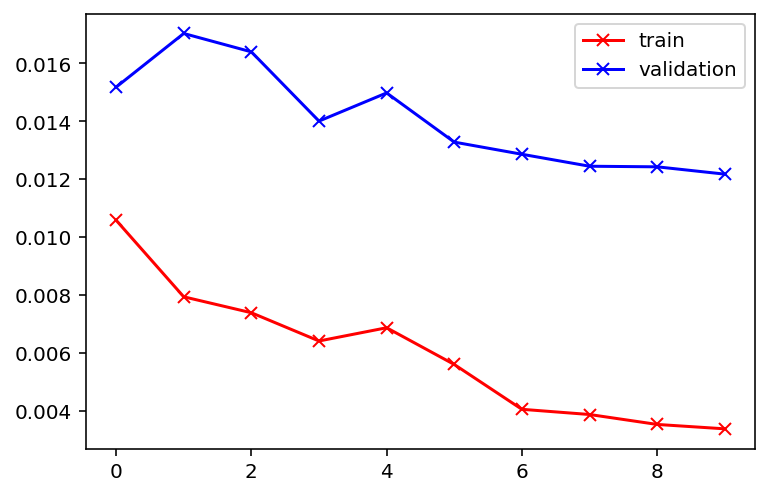

In [64]:
plt.plot(range(0, n_epochs), train_loss, 'rx-', label='train')
plt.plot(range(0, n_epochs), val_loss, 'bx-', label='validation')
plt.legend()

Text(0.5, 1.0, 'PanCancer Train: Siamese')

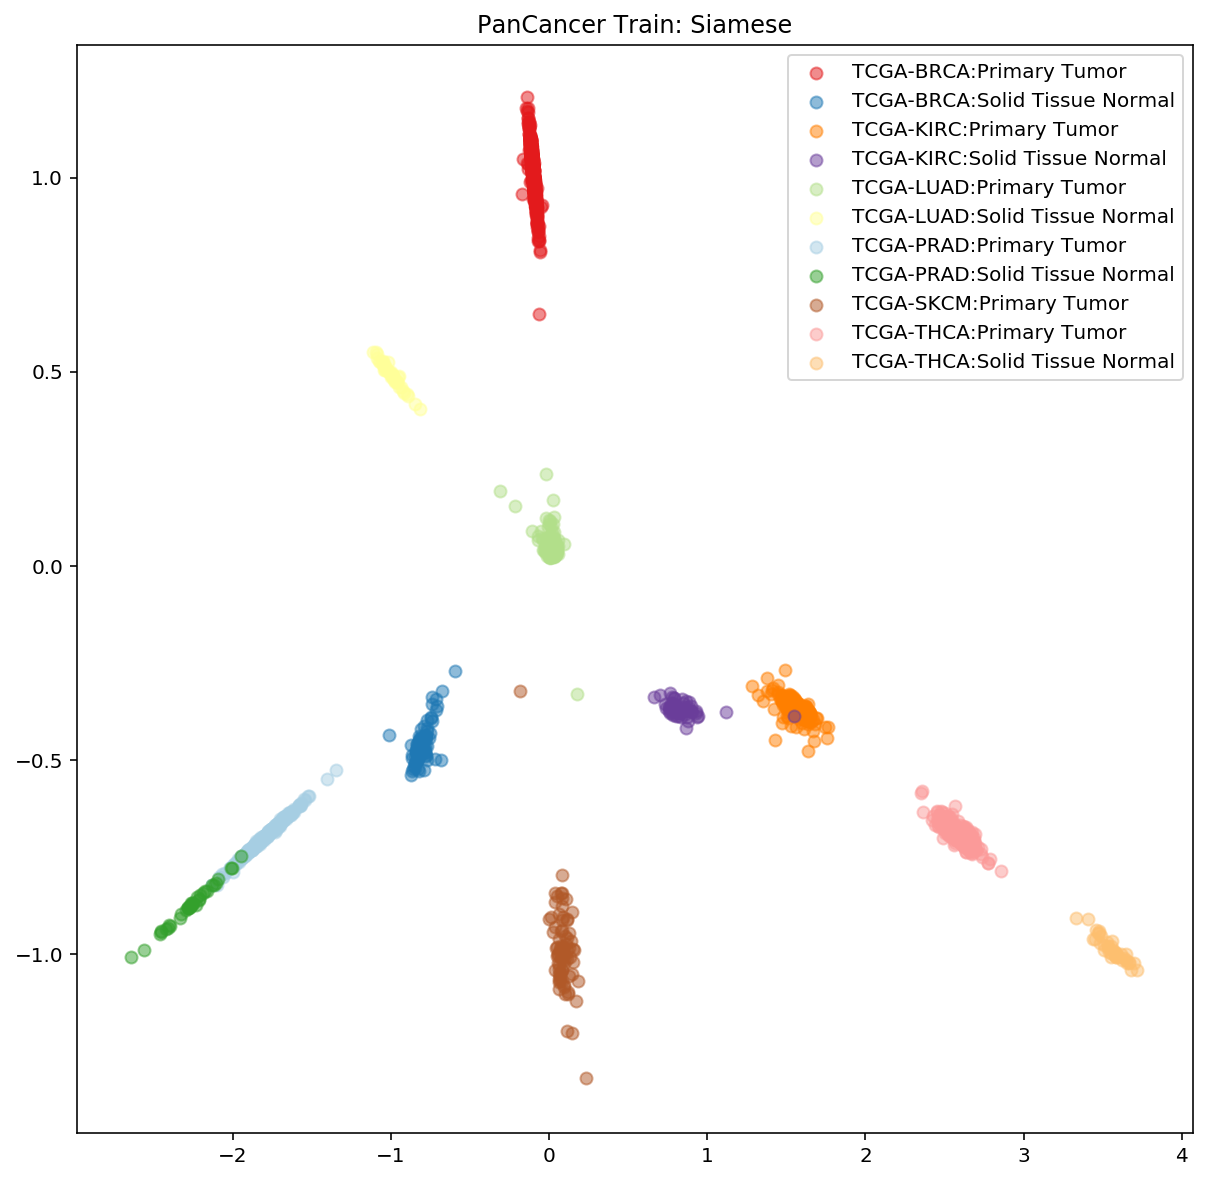

In [65]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset.labels_dict)
plt.title('PanCancer Train: Siamese')

Frusturatingly the test_loader(shuffl=False) only works to load here because it has been specified for 1 sample at a time. The data order is the same as siamese_test_loader(shuffle=False).

Text(0.5, 1.0, 'PanCancer Test: Siamese')

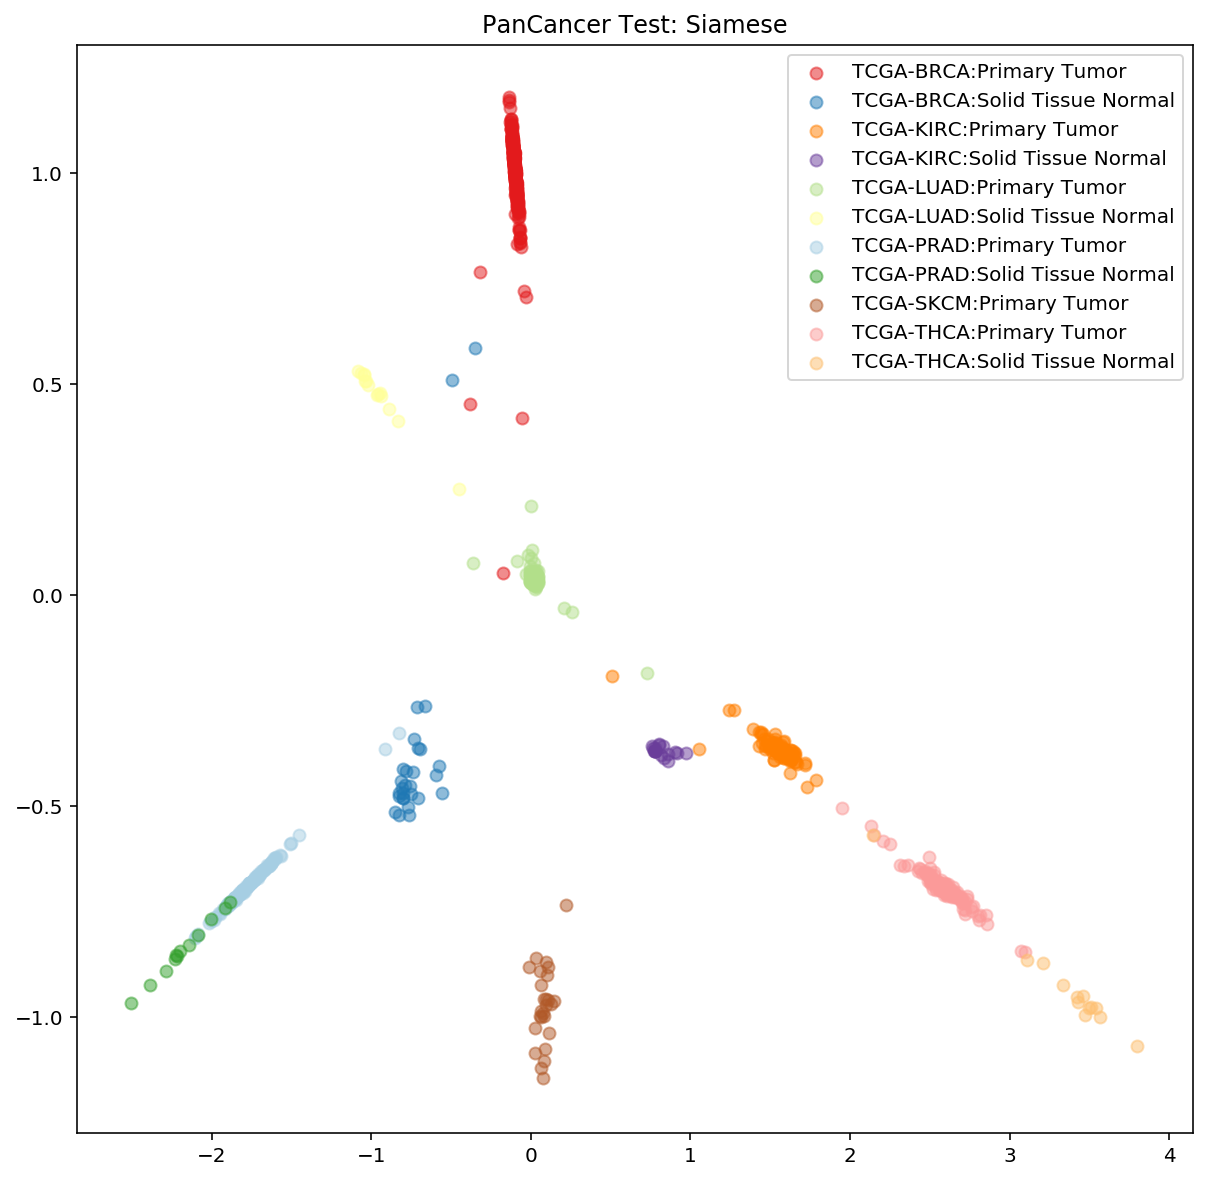

In [66]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset.labels_dict)
plt.title('PanCancer Test: Siamese')

## Save Model

In [67]:
save = False
if save:
    torch.save(model.state_dict(), "../../data/TCGA/models/220_seminar_results.pt")

## Kmeans Cluster and NMI Evaluation

In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_mutual_info_score as aNMI

In [69]:
n_clusters = len(siamese_test_dataset.labels_dict)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
siamese_clusters = kmeans.fit_predict(val_embeddings_baseline)

In [70]:
NMI(siamese_clusters, val_labels_baseline)

0.9453818164437667

## Project Metastatic SKCM

In [71]:
%time
projection_skcm = samples[samples[target] == 'TCGA-SKCM:Metastatic']
projection = pd.concat([test, projection_skcm]).sample(frac=1)
projection.shape

projection[target] = projection[target].astype('category')

CPU times: user 9 µs, sys: 4 µs, total: 13 µs
Wall time: 28.1 µs


(1228, 10)

In [72]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../../data/TCGA/rna-seq_pan/"
batch_size = 1

In [54]:
%time
projection_dataset = TCGA(root_dir, samples=projection, train=False, target=target, log=True)

CPU times: user 18 µs, sys: 6 µs, total: 24 µs
Wall time: 46.7 µs


In [55]:
%time
projection_dataset.data = pd.DataFrame(scaler.transform(projection_dataset.data),
                                 index=projection_dataset.data.index,
                                 columns=projection_dataset.data.columns)

CPU times: user 17 µs, sys: 5 µs, total: 22 µs
Wall time: 54.1 µs


In [56]:
# subset features
projection_dataset.data = projection_dataset.data.loc[:,protein_overlap_idx]
# rename
projection_dataset.data = projection_dataset.data.rename(columns=ensembl_dict)

projection_loader = torch.utils.data.DataLoader(projection_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [57]:
projection_dataset.labels_dict
siamese_test_dataset.labels_dict

{'TCGA-BRCA:Primary Tumor': 0,
 'TCGA-BRCA:Solid Tissue Normal': 1,
 'TCGA-KIRC:Primary Tumor': 2,
 'TCGA-KIRC:Solid Tissue Normal': 3,
 'TCGA-LUAD:Primary Tumor': 4,
 'TCGA-LUAD:Solid Tissue Normal': 5,
 'TCGA-PRAD:Primary Tumor': 6,
 'TCGA-PRAD:Solid Tissue Normal': 7,
 'TCGA-SKCM:Metastatic': 8,
 'TCGA-SKCM:Primary Tumor': 9,
 'TCGA-THCA:Primary Tumor': 10,
 'TCGA-THCA:Solid Tissue Normal': 11}

{'TCGA-BRCA:Primary Tumor': 0,
 'TCGA-BRCA:Solid Tissue Normal': 1,
 'TCGA-KIRC:Primary Tumor': 2,
 'TCGA-KIRC:Solid Tissue Normal': 3,
 'TCGA-LUAD:Primary Tumor': 4,
 'TCGA-LUAD:Solid Tissue Normal': 5,
 'TCGA-PRAD:Primary Tumor': 6,
 'TCGA-PRAD:Solid Tissue Normal': 7,
 'TCGA-SKCM:Primary Tumor': 8,
 'TCGA-THCA:Primary Tumor': 9,
 'TCGA-THCA:Solid Tissue Normal': 10}

Text(0.5, 1.0, 'PanCancer Metastatic: Siamese')

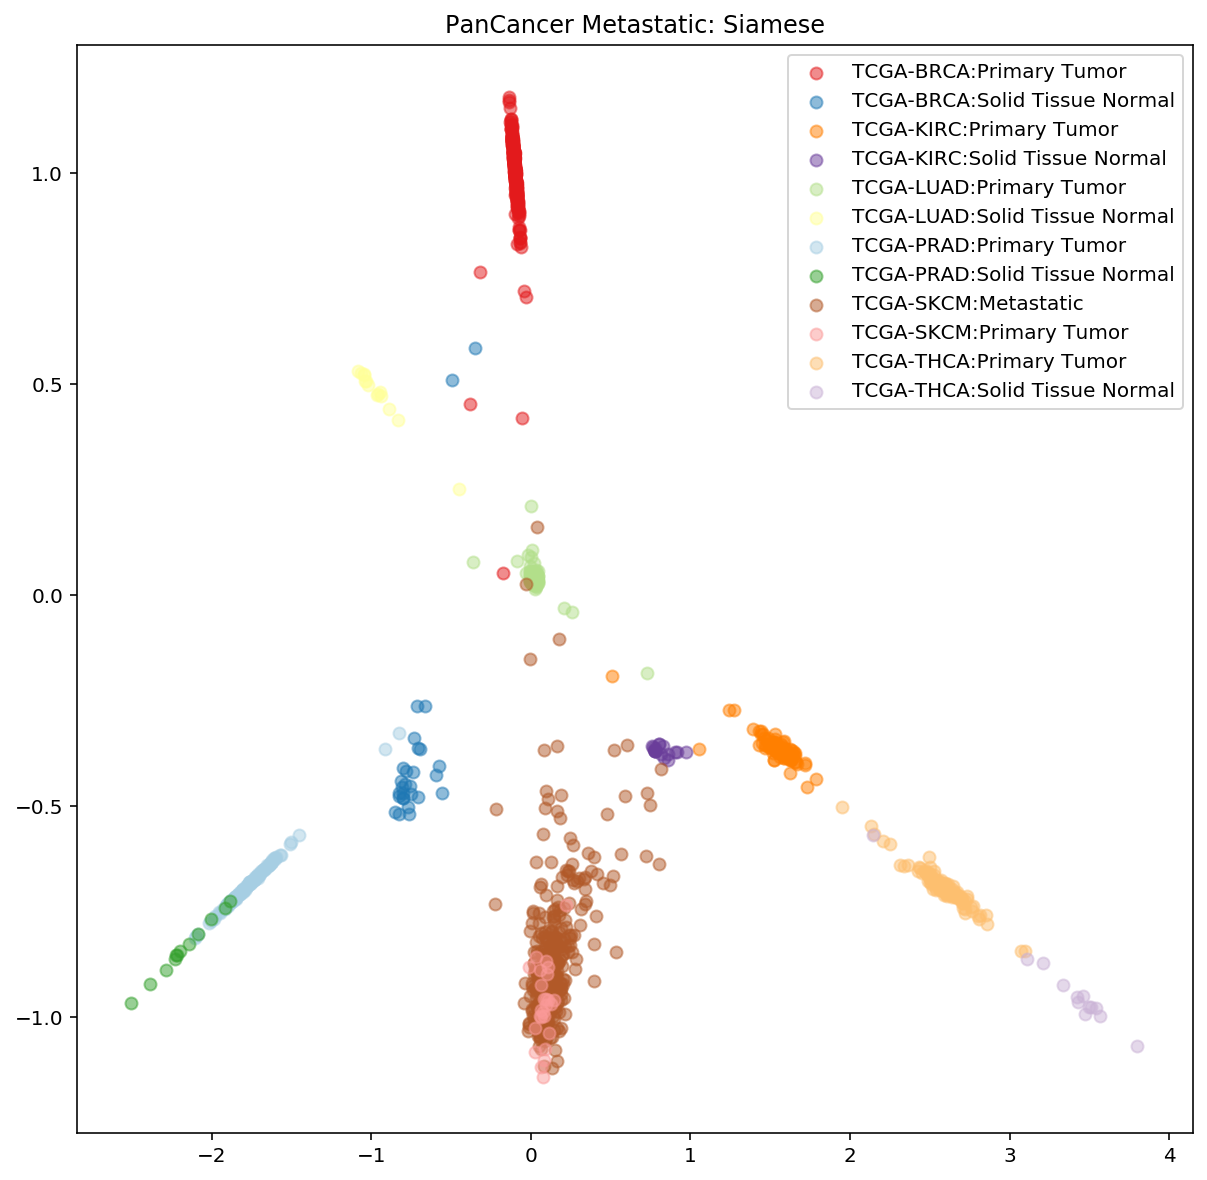

In [73]:
proj_embeddings_baseline, proj_labels_baseline = vis.extract_embeddings(projection_loader, model)
vis.plot_embeddings(proj_embeddings_baseline, proj_labels_baseline, projection_dataset.labels_dict)
plt.title('PanCancer Metastatic: Siamese')

## SKCM Clinical Info

In [74]:
skcm_clinical = pd.read_csv("../../data/TCGA/clinical/skcm/https:/api.gdc.cancer.gov/data/58cbbc07-5ec4-47c7-9295-11ccbf7693f4/nationwidechildrens.org_clinical_patient_skcm.txt", 
                            sep="\t")
# remove extra header
skcm_clinical = skcm_clinical.loc[2:, :].reset_index(drop=True)
skcm_clinical.head()
skcm_clinical.shape

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,prospective_collection,retrospective_collection,birth_days_to,gender,height_cm_at_diagnosis,weight_kg_at_diagnosis,race,ethnicity,history_other_malignancy,history_neoadjuvant_treatment,tumor_status,vital_status,last_contact_days_to,death_days_to,primary_melanoma_known_dx,primary_multiple_at_dx,primary_at_dx_count,primary_location,breslow_thickness_at_diagnosis,clark_level_at_diagnosis,primary_melanoma_tumor_ulceration,primary_melanoma_mitotic_rate,radiation_therapy_to_primary,initial_pathologic_dx_year,age_at_diagnosis,ajcc_staging_edition,ajcc_tumor_pathologic_pt,ajcc_nodes_pathologic_pn,ajcc_metastasis_pathologic_pm,ldh_level,ajcc_pathologic_tumor_stage,submitted_tumor_dx_days_to,submitted_tumor_site,metastatic_tumor_site,primary_melanoma_skin_type,prior_radiation_therapy,history_neoadjuvant_treatment.1,history_neoadjuvant_tx_type,ifn_tx_90_days_prior_to_resection,radiation_treatment_adjuvant,pharmaceutical_tx_adjuvant,new_tumor_event_dx_indicator,new_tumor_event_prior_to_bcr_tumor,melanoma_primary_count,clinical_M,clinical_N,clinical_T,clinical_stage,days_to_initial_pathologic_diagnosis,days_to_patient_progression_free,days_to_tumor_progression,disease_code,extranodal_involvement,icd_10,icd_o_3_histology,icd_o_3_site,informed_consent_verified,patient_id,project_code,stage_other,tissue_source_site,tumor_tissue_site_other
0,5564E6A7-2195-4B0D-994E-B0617B58E889,TCGA-3N-A9WB,2014-5-29,YES,NO,-26176,MALE,175,78,WHITE,NOT HISPANIC OR LATINO,No,No,WITH TUMOR,Dead,[Not Available],518,YES,NO,[Not Available],Distant Metastasis,0.7,III,NO,2,NO,2012,71,7th,T1a,NX,M0,[Not Available],Stage IA,426,Trunk,Left Flank,Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,NO,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C44.5,8720/3,C44.5,YES,A9WB,[Not Available],[Not Available],3N,[Not Applicable]
1,551E071A-C290-4B48-9000-F64C2A44DFB7,TCGA-3N-A9WC,2014-5-29,YES,NO,-30286,MALE,183,68,WHITE,NOT HISPANIC OR LATINO,No,No,WITH TUMOR,Alive,1856,[Not Applicable],YES,NO,1,Regional Lymph Node,1.8,IV,YES,4,NO,2009,82,6th,T2b,NX,M0,[Not Available],Stage IIA,1644,Trunk,[Not Available],Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,NO,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C77.3,8720/3,C77.3,YES,A9WC,[Not Available],[Not Available],3N,[Not Applicable]
2,A29A20E3-5C2C-4F37-B93E-AE9EBC46EC53,TCGA-3N-A9WD,2014-5-29,YES,NO,-30163,MALE,183,116,WHITE,NOT HISPANIC OR LATINO,No,No,WITH TUMOR,Dead,[Not Available],395,YES,NO,1,Regional Lymph Node,1.25,III,NO,4,NO,2013,82,7th,T2a,N1a,M0,[Not Evaluated],Stage IIIA,183,Other Specify,[Not Available],Non-glabrous skin,NO,NO,[Not Available],[Not Available],YES,NO,YES,NO,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C77.0,8720/3,C77.0,YES,A9WD,[Not Available],[Not Available],3N,Posterior Ear
3,3DD5A206-D7F3-42F1-B9CC-4B31C76D495D,TCGA-BF-A1PU,2013-4-25,YES,NO,-17025,FEMALE,160,58,WHITE,[Unknown],No,No,TUMOR FREE,Alive,387,[Not Applicable],YES,NO,1,Primary Tumor,13,III,YES,[Not Available],NO,2010,46,7th,T4b,N0,M0,[Not Available],Stage IIC,0,Extremities,[Not Available],Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,NO,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C44.9,8720/3,C44.9,YES,A1PU,[Not Available],[Not Available],BF,[Not Applicable]
4,EFF78AF6-0F68-49B9-866B-0D511606F2B1,TCGA-BF-A1PV,2013-4-25,YES,NO,-27124,FEMALE,160,70,WHITE,[Unknown],No,No,TUMOR FREE,Alive,14,[Not Applicable],YES,NO,1,Primary Tumor,9,IV,YES,[Not Available],NO,2010,74,7th,T4b,N0,M0,[Not Available],Stage IIC,0,Trunk,[Not Available],Non-glabrous skin,NO,NO,[Not Available],[Not

(470, 65)

In [60]:
skcm_metas_dist = skcm_clinical[skcm_clinical['primary_location'] == 'Distant Metastasis']
skcm_metas_dist = skcm_clinical[skcm_clinical['metastatic_tumor_site'] == 'Lung']
skcm_metas_dist.shape

(5, 65)

In [61]:
bool_skcm_metas_dist = projection_dataset.samples['Case ID'].isin(skcm_metas_dist['bcr_patient_barcode'])
bool_skcm_metas_dist.sum()

5

Text(0.5, 1.0, 'PanCancer Metastatic: Siamese')

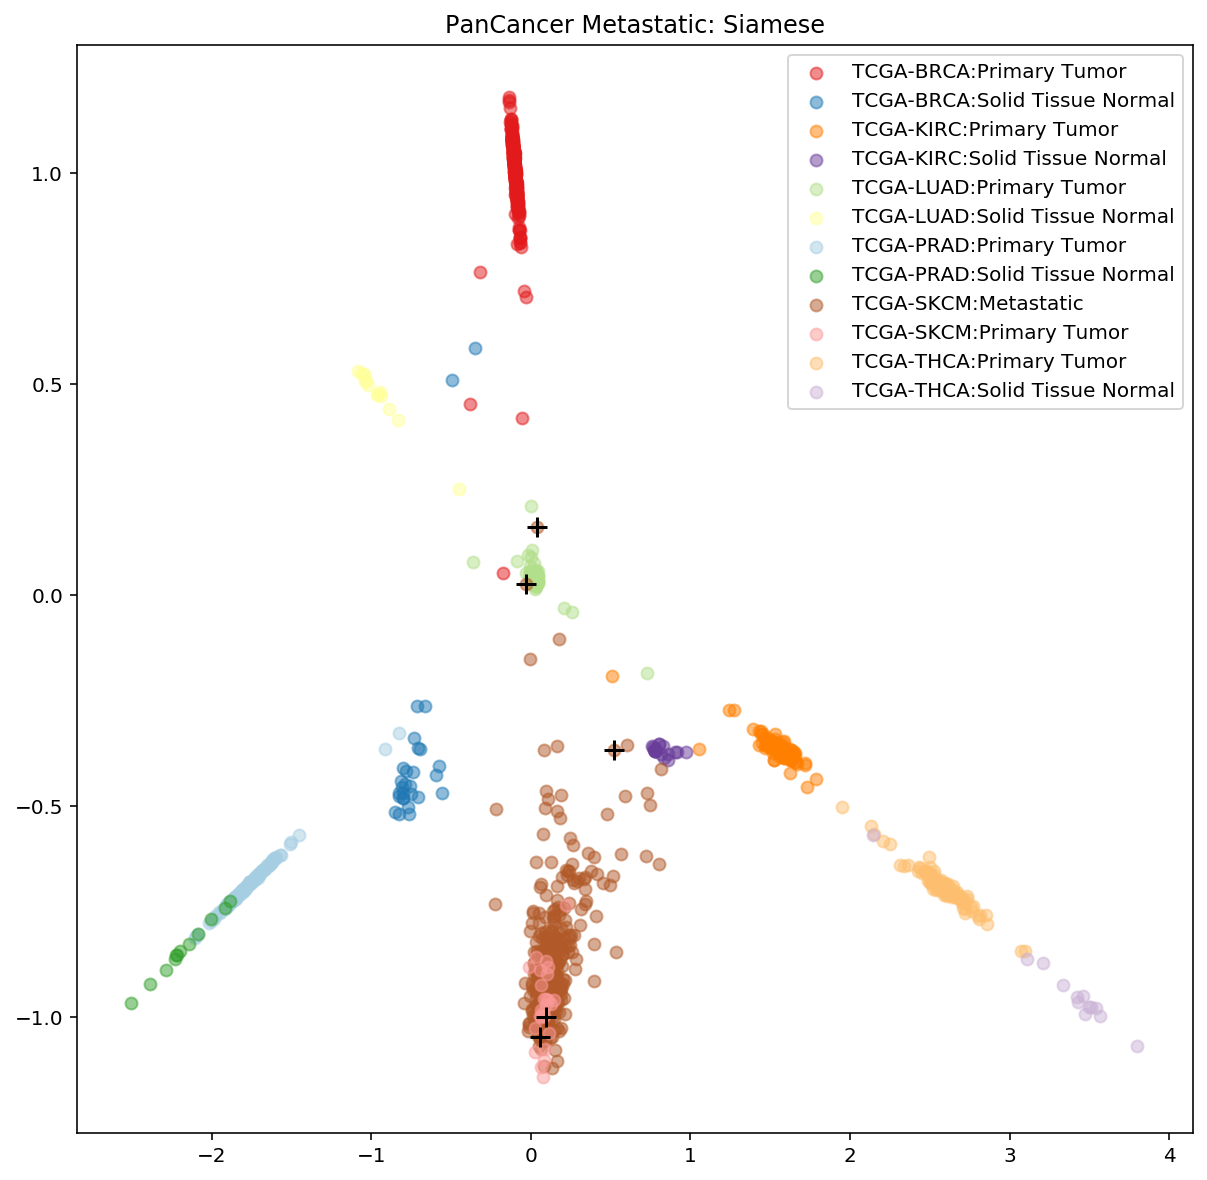

In [75]:
#proj_embeddings_baseline, proj_labels_baseline = vis.extract_embeddings(projection_loader, model)
vis.plot_embeddings(proj_embeddings_baseline, proj_labels_baseline, projection_dataset.labels_dict)
# add distant metastasis markers
plt.scatter(proj_embeddings_baseline[bool_skcm_metas_dist,0], 
            proj_embeddings_baseline[bool_skcm_metas_dist,1],
            marker="+", color='k', s=100)
plt.title('PanCancer Metastatic: Siamese')

In [135]:
df = pd.concat([projection_dataset.samples[['Meta ID', 'Project ID', 'Sample Type']].reset_index(drop=True), pd.DataFrame(proj_embeddings_baseline).reset_index(drop=True)], axis=1, 
               ignore_index=False, sort=False)
df

,Meta ID,Project ID,Sample Type,0,1
0,TCGA-SKCM:Metastatic,TCGA-SKCM,Metastatic,0.060266,-0.966978
1,TCGA-SKCM:Metastatic,TCGA-SKCM,Metastatic,0.082775,-0.965883
2,TCGA-SKCM:Metastatic,TCGA-SKCM,Metastatic,0.192661,-0.959581
3,TCGA-KIRC:Primary Tumor,TCGA-KIRC,Primary Tumor,1.622752,-0.421694
4,TCGA-SKCM:Metastatic,TCGA-SKCM,Metastatic,0.142595,-0.905519
...,...,...,...,...,...
1223,TCGA-BRCA:Primary Tumor,TCGA-BRCA,Primary Tumor,-0.101400,1.011242
1224,TCGA-SKCM:Metastatic,TCGA-SKCM,Metastatic,0.081907,-0.870506
1225,TCGA-KIRC:Primary Tumor,TCGA-KIRC,Primary Tumor,1.640888,-0.368311
1226,TCGA-BRCA:Solid Tissue Normal,TCGA-BRCA,Solid Tissue Normal,-0.805175,-0.455776


In [148]:
import seaborn as sns
sns.set(rc={'figure.figsize':(18.7,14.27)})

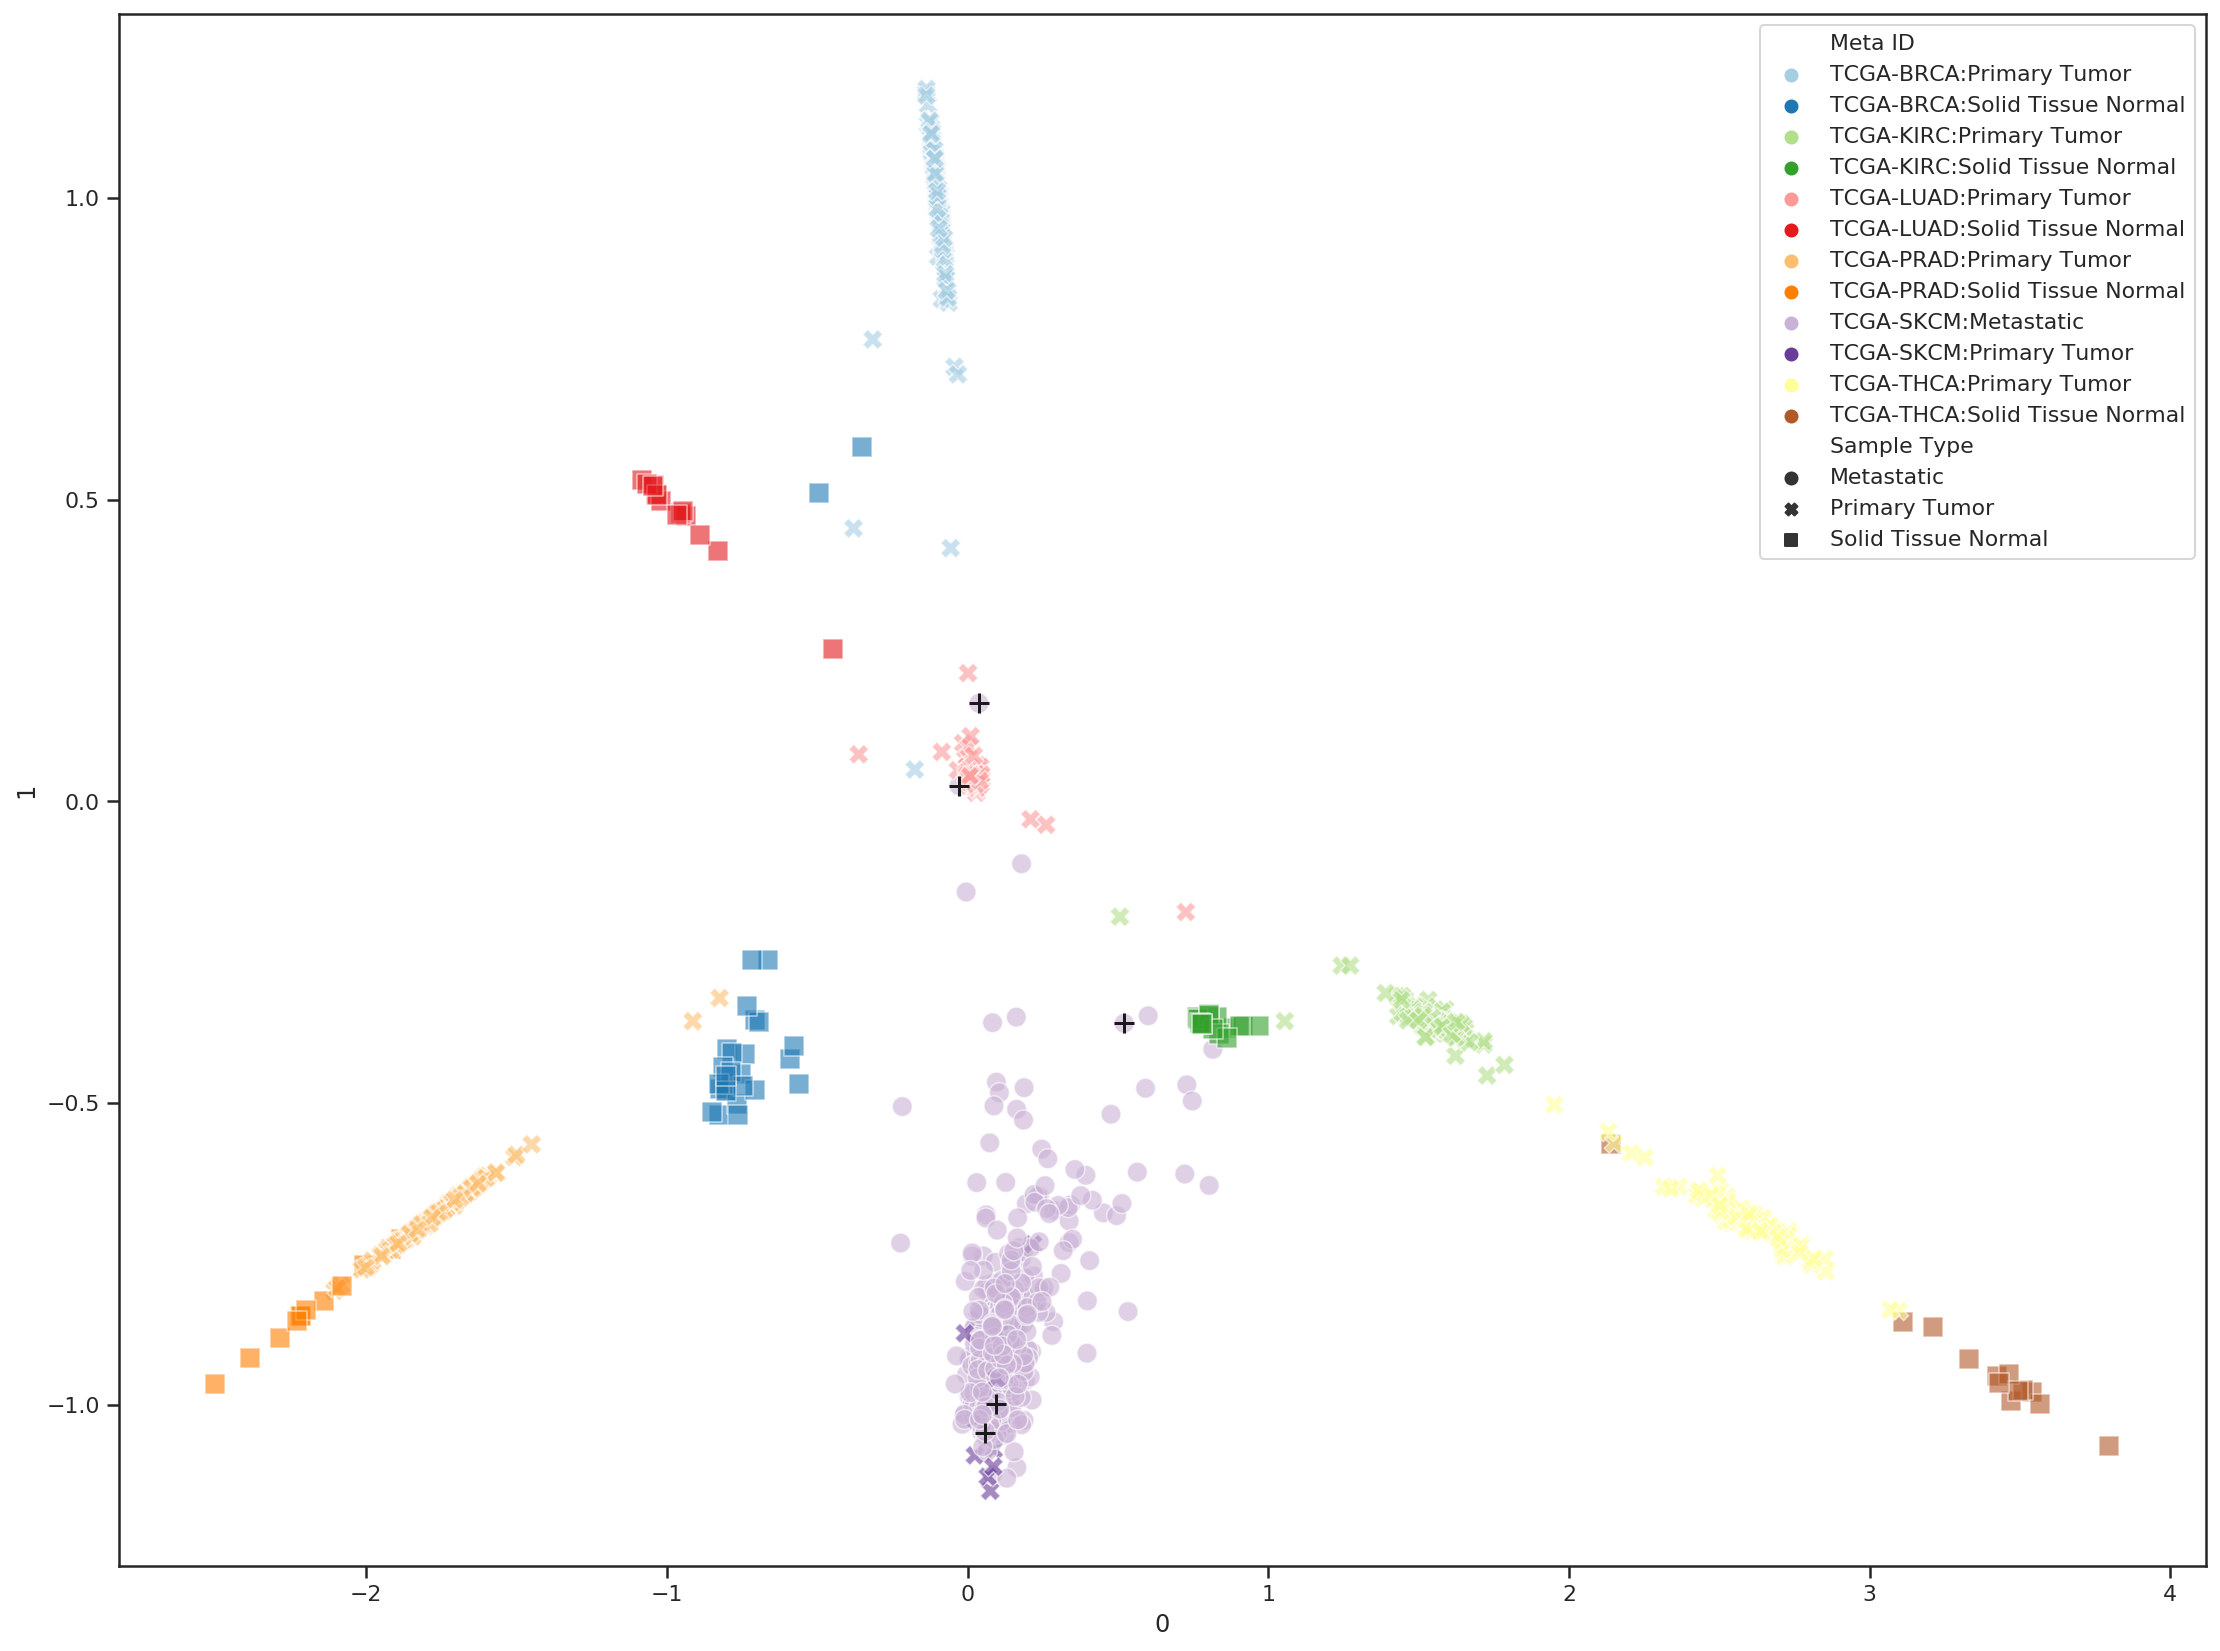

In [151]:
sns.set_style("ticks")
sns.scatterplot(x=0, y=1, hue="Meta ID", style='Sample Type', palette="Paired", data=df,
                s=100, alpha=0.6)
# add distant metastasis markers
plt.scatter(proj_embeddings_baseline[bool_skcm_metas_dist,0], 
            proj_embeddings_baseline[bool_skcm_metas_dist,1],
            marker="+", color='k', s=100)

In [80]:
from sklearn.metrics import pairwise_distances

In [82]:
pairwise_distances(proj_embeddings_baseline).shape

(1228, 1228)